<a href="https://github.com/ml-dafe/ml_mipt_dafe/tree/main/hw2/prototypical_omniglot_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Netwoks on the Omniglot dataset

Заданием является воспроизведение результатов статьи [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

## Import libraries

In [1]:
import os
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.tensorboard import SummaryWriter

In [2]:
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
logger = SummaryWriter()

Omniglot dataset - [the official GitHub repository](https://github.com/brendenlake/omniglot)

## Read data

Набор данных Omniglot содержит 1623 различных рукописных символа из 50 различных алфавитов. Каждый из 1623 персонажей был нарисован онлайн с помощью Amazon Mechanical Turk 20 разными людьми (то есть 20 примеров на персонажа).
Он разделен на фоновый набор из 30 алфавитов и оценочный набор из 20 алфавитов. Мы будем использовать фоновый набор для обучения и оценочный набор для тестирования.

### Задание № 1 - реализуйте функцию чтения данных

Вы можете увеличить размер обучающей выборки, если для каждого символа введете 4 класса, соответствующих повороту на 90 градусов. То есть из одного класса сделать x4.

In [44]:
def read_alphabets(alphabet_directory_path):
    """
    Reads all the characters from a given alphabet_directory
    Args:
      alphabet_directory_path (str): path to diretory with files
    Returns:
      datax (np.array): array of path name of images
      datay (np.array): array of labels
    """
    datax = []  # all file names of images
    datay = []  # all class names 

    for label in os.listdir(alphabet_directory_path):
        datay += [alphabet_directory_path.split("/")[-2]+ "/" + label]
        datay += [alphabet_directory_path.split("/")[-2]+ "/" + label +"_90"]
        datay += [alphabet_directory_path.split("/")[-2]+ "/" + label +"_180"]
        datay += [alphabet_directory_path.split("/")[-2]+ "/" + label +"_270"]
        class_set = []
        class_set_90 = []
        class_set_180 = []
        calss_set_270 = []
        
        for charecter_name in os.listdir(alphabet_directory_path + label):
            fname = alphabet_directory_path + label + "/" + charecter_name
            image = cv2.resize(cv2.imread(fname), (28, 28))
            class_set += [image]
            class_set_90 += [cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)]
            class_set_180 += [cv2.rotate(image, cv2.ROTATE_180)]
            calss_set_270 += [cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)]
        
        datax += [class_set]
        datax += [class_set_90]
        datax += [class_set_180]
        datax += [calss_set_270]
        
        


    return np.array(datax), np.array(datay)

In [45]:
def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    results = [read_alphabets(base_directory + '/' + directory + '/') for directory in os.listdir(base_directory)]
    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.concatenate([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [46]:
datax, datay = read_alphabets("C:/Max/Proga/GRISHIN_ML/ml_mipt_dafe/homeworks/hw_01/data/images_background/Alphabet_of_the_Magi/")
datax.shape, datay.shape

((80, 20, 28, 28, 3), (80,))

In [47]:
trainx, trainy = read_images('data/images_background')

In [48]:
testx, testy = read_images('data/images_evaluation')

In [49]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((3856, 20, 28, 28, 3), (3856,), (2636, 20, 28, 28, 3), (2636,))

## Create samples

In [50]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    """
    Picks random sample of size n_support + n_querry, for n_way classes
    Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
    Returns:
      (dict) of:
        (torch.Tensor): sample of images
        . Size (n_way, n_support + n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
    """
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)

    for cls in K:
        datax_cls = datax[datay == cls][0]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support + n_query)]
        sample.append(sample_cls)
        
      
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    sample = sample.permute(0, 1, 4, 2, 3)
    return ({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [51]:
def display_sample(sample, prediction=None, n_sup=None):
    """
    Displays sample in a grid
    Args:
      sample (torch.Tensor): sample of images to display
      prediction (torch.Tensor): sample of predictions to display
    """
    
    if prediction is None:
        #need 4D tensor to create grid, currently 5D
        sample_4D = sample.view(sample.shape[0] * sample.shape[1], *sample.shape[2:])
        #make a grid
        out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
        plt.figure(figsize=(16, 7))
        plt.imshow(out.permute(1, 2, 0))
        plt.axis("off")
        return
    
    fig, axis = plt.subplots(sample.shape[0], sample.shape[1], figsize=(16, 7))
    for i in range(sample.shape[0]):
        for j in range (sample.shape[1]):
            axis[i, j].imshow(np.clip(sample[i, j].permute(1, 2, 0).numpy(), 0, 1))
            if j < n_sup:
                axis[i, j].text(10, 0, "Support vec")
                axis[i, j].axis("off")
            else:
                axis[i, j].text(10, 0, f"Prediction: {prediction[i, j - n_sup]}")
                axis[i, j].axis("off")
    

В качестве примера возьмем образец и отобразим его

*   n_way = 8
*   n_support = 5
*   n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


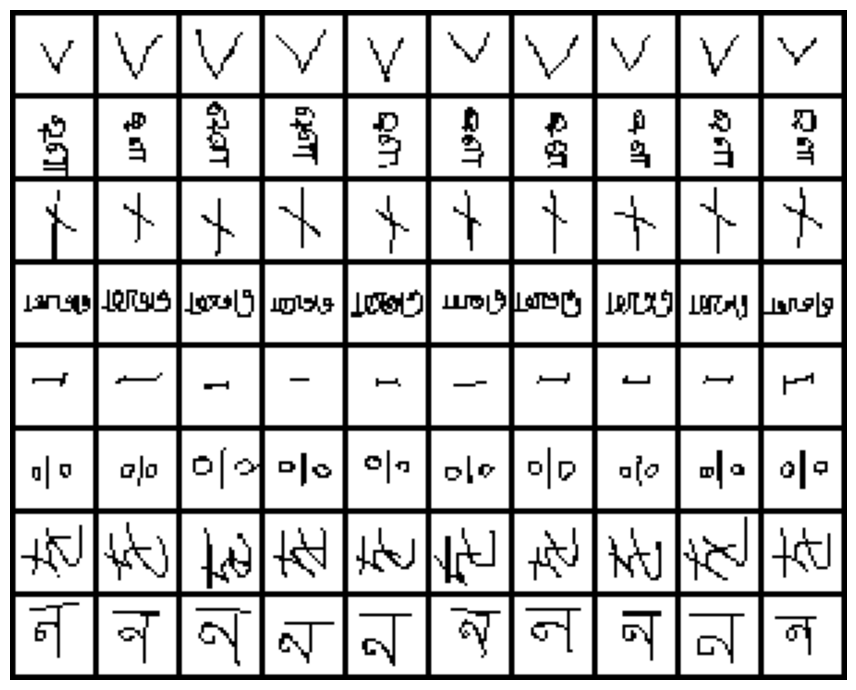

In [52]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [53]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

## Build model

Модель берет на вход (28x28x3) и возвращает вектор-столбец длиной 64. Каждый модуль модели состоит из свертки 3 × 3 с 64 фильтрами, слоя пакетной нормализации, нелинейности ReLU и слоя максимального объединения 2 × 2 (см. описание задания).

Применительно к изображениям Omniglot 28 × 28 эта архитектура приводит к 64-мерному выходному пространству.

### Задание № 2 - реализуйте энкодер на основе сверточной нейроннй сети

In [54]:
class ElementaryBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, out_features, 3, bias=False, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self, x):
        return self.block(x)

In [55]:
class ProtoNetEncoder(nn.Module):
    def __init__(self, x_dim, hid_dim, z_dim) -> None:
        super().__init__()
        
        self.block1 = ElementaryBlock(x_dim, hid_dim)
        self.block2 = ElementaryBlock(hid_dim, hid_dim)
        self.block3 = ElementaryBlock(hid_dim, hid_dim)
        self.block4 = ElementaryBlock(hid_dim, z_dim)
        
        
    def forward(self, x):
        b1 = self.block1(x)
        b2 = self.block2(b1)
        b3 = self.block3(b2)
        b4 = self.block4(b3)
        return b4

### Задание № 3 - реализуйте Prototypical Networks (``` set_forward_loss ```)

In [56]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        """
        Args:
            encoder : CNN encoding the images in sample
            n_way (int): number of classes in a classification task
            n_support (int): number of labeled examples per class in the support set
            n_query (int): number of labeled examples per class in the query set
        """
        super(ProtoNet, self).__init__()
        self.encoder = encoder.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat (predict)
        """
        sample_images = sample['images'].to(DEVICE)
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']
        
        # Изменяем размер входного тензора к виду (N, C, H, W)
        # чтобы за один раз прогнать все картинки через модель
        # и возвращаем её к размерам (n_way, n_support + n_query, embed_size)
        vectors = self.encoder(
            sample_images.reshape(-1, 3, 28, 28)
        ).reshape(n_way, n_support + n_query, 64)
        
        # Считаем опорные вектора для каждого класса как среднее
        # между опорными векторами соответствующего класса
        # (n_way, n_support, dim) -> (n_way, 1, dim)
        support_vectors = torch.mean(
            vectors[:, :n_support, :],
            dim=1,
            keepdim=True
        ).reshape(n_way, 1, 64)
        
        # вычленяем вектора, которые являются векотрами запроса
        # и меняем размерность выходного тензора как подготовка 
        # к векторизированному вычислению расстояний между векторами
        query_vectors = vectors[:, n_support:, :].reshape(n_way, 1, n_query, 64)

        # print(vectors.shape)
        # print(support_vectors.shape)
        # print(query_vectors.shape)
        
        y_hat = 0
        loss_val = 0
        acc_val = torch.tensor(0)
        log_softmax = nn.LogSoftmax(dim=1)
        
        # Расстояние между опорными векторами для каждого вектора запроса
        distances = - torch.linalg.norm(support_vectors - query_vectors, dim=3)
        
        idxs = torch.arange(n_way)
        logits = - log_softmax(distances)
                
        loss_val = torch.mean(logits[idxs, idxs])   

        targets = idxs.reshape(n_way, 1).repeat(1, n_query).to(DEVICE)
        predict = torch.argmin(logits, dim=1).to(DEVICE)
        
        acc_val = torch.mean(targets == predict, dtype=torch.float32) 
        
        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'prediction': predict.detach().cpu().numpy(),
            'y_hat': y_hat
        }

Cell with test code:

<!-- 

support = torch.tensor([
    [1, 1],
    [2, 2],
    [3, 3]
], dtype=float).reshape(3, 1, 2)

query = torch.tensor([
    [[1, 1], [4, 1], [0, 0], [5, 5]],
    [[2, 2], [5, 2], [0, 0], [2, 2]],
    [[3, 3], [6, 3], [0, 0], [-1, -1]]
], dtype=float).reshape(3, 1, 4, 2)

a.shape, b.shape

normed = torch.linalg.norm(query - support, dim=3)
print(normed.shape)

lsf = nn.LogSoftmax(dim = 1)
logits = -lsf(normed)


idxs = torch.arange(3)

print(logits)
print(logits.shape)

targets = idxs.reshape(3, 1).repeat(1, 4)
print(targets)
logits[idxs, idxs], torch.argmax(logits, dim=1), idxs.reshape(3, 1), torch.mean(targets == torch.argmax(logits, dim=1), dtype=float) -->

End of code

In [57]:
def load_protonet_conv(**kwargs):
    """
    Loads the prototypical network model
    Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
    Returns:
      Model (Class ProtoNet)
    """
    encoder = ProtoNetEncoder(kwargs["x_dim"][0], kwargs["hid_dim"], kwargs["z_dim"]) 
    return ProtoNet(encoder)

## Train

### Задание № 4 - добавьте логирование в процесс обучения (wandb/neptune/tensorboard)

In [58]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0  # epochs done so far
    stop = False  # status to know when to stop
    model.train()
    
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0
              
        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch + 1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)

            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)

            running_loss += output['loss']
            running_acc += output['acc']
            
            if episode % 50 == 0:
                # history["loss"] += [output['loss']]
                # history["acc"] += [output['acc']]
                logger.add_scalar("Mean train loss", output["loss"], episode)
                logger.add_scalar("Mean train accuracy", output["acc"], episode)
            
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()

In [59]:
model = load_protonet_conv(
    x_dim=(3, 28, 28),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000

In [60]:
history = train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

Epoch 1 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1233 Acc: 0.9718


Epoch 2 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0434 Acc: 0.9868


Epoch 3 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0329 Acc: 0.9894


Epoch 4 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0280 Acc: 0.9906


Epoch 5 train:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0251 Acc: 0.9916


## Test

In [61]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        with torch.no_grad():
            loss, output = model.set_forward_loss(sample)   
        running_loss += output['loss']
        running_acc += output['acc']
        
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [78]:
test_episode = 1000

In [79]:
n_way = 5
n_support = 1
n_query = 5

test(model, testx, testy, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0523 Acc: 0.9837


In [80]:
n_way = 5
n_support = 5
n_query = 5

test(model, testx, testy, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0137 Acc: 0.9963


In [81]:
n_way = 20
n_support = 1
n_query = 5

test(model, testx, testy, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.1560 Acc: 0.9532


In [82]:
n_way = 20
n_support = 5
n_query = 5

test(model, testx, testy, n_way, n_support, n_query, test_episode)

  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 0.0451 Acc: 0.9878


При разных запусках результаты могу варьироваться в пределах +- 0.05 

<ins>**Результаты**</ins>

<table>
  <tr>
    <td></td>
    <td colspan="2" align="center">5-way</td>
    <td colspan="2" align="center">20-way</td>
  </tr>
  <tr>
    <td></td>
    <td>1-shot</td>
    <td>5-shot</td>
    <td>1-shot</td>
    <td>5-shot</td>
  </tr>
  <tr>
    <td>Paper</td>
    <td>98.8%</td>
    <td>99.7%</td>
    <td>96.0%</td>
    <td>98.9%</td>
  </tr>
    <tr>
    <td>My results</td>
    <td>98.55%</td>
    <td>99.55%</td>
    <td>95.24%</td>
    <td>98.83%</td>
  </tr>
</table>


## Test on specific example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


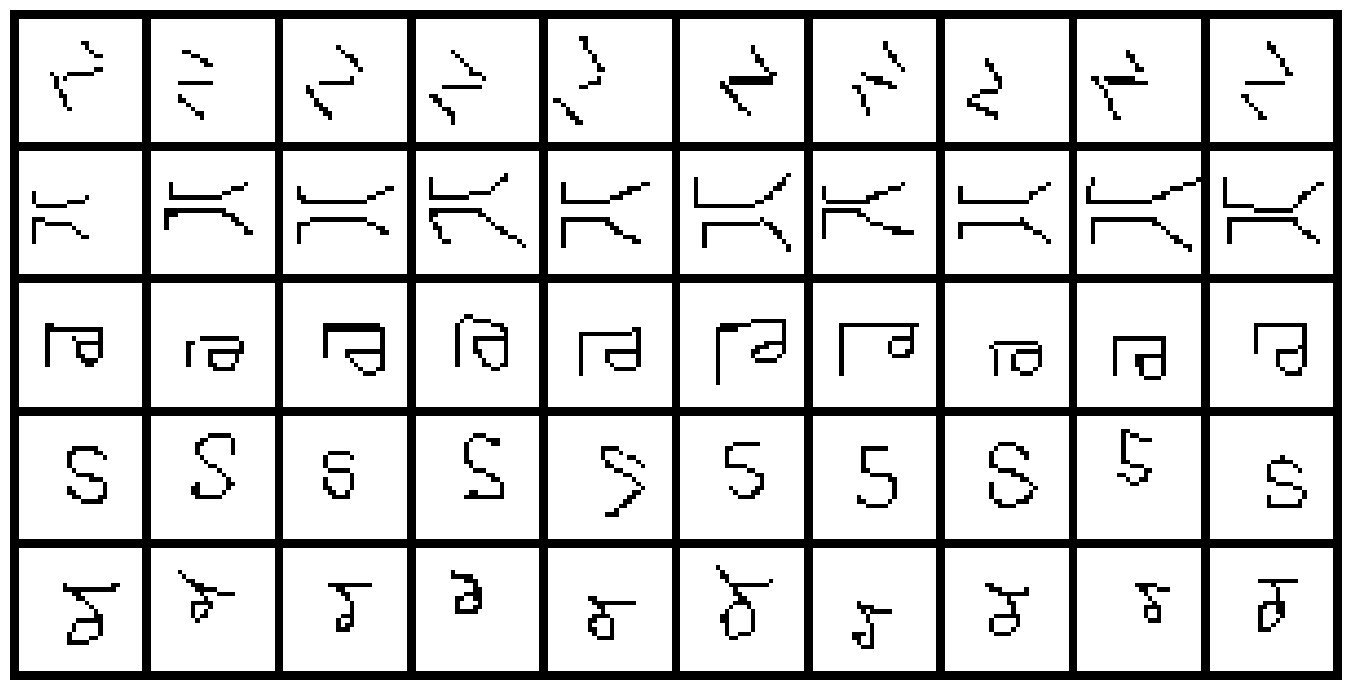

In [64]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [65]:
loss, output = model.set_forward_loss(my_sample)

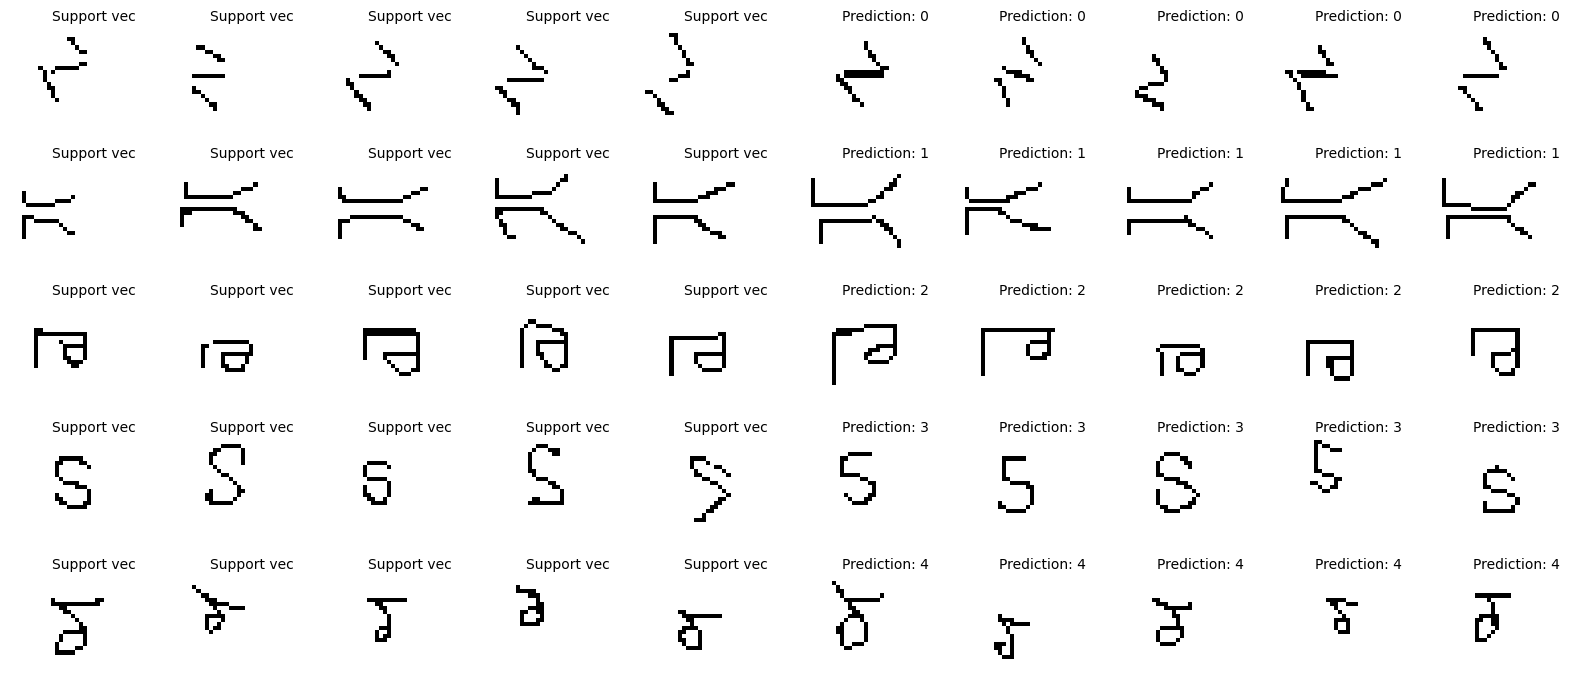

In [66]:
display_sample(my_sample['images'], prediction=output["prediction"], n_sup=n_support)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


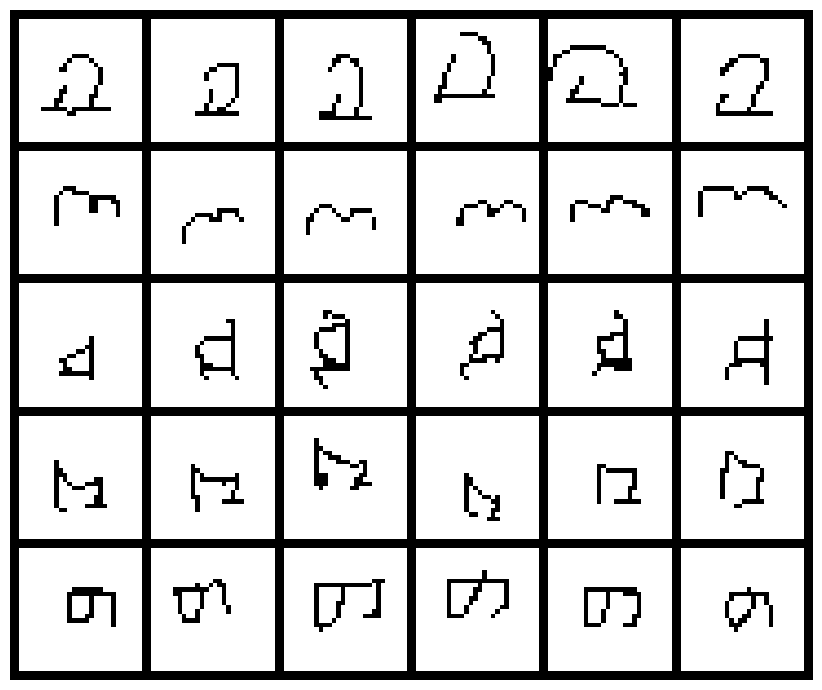

In [69]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [70]:
loss, output = model.set_forward_loss(my_sample)

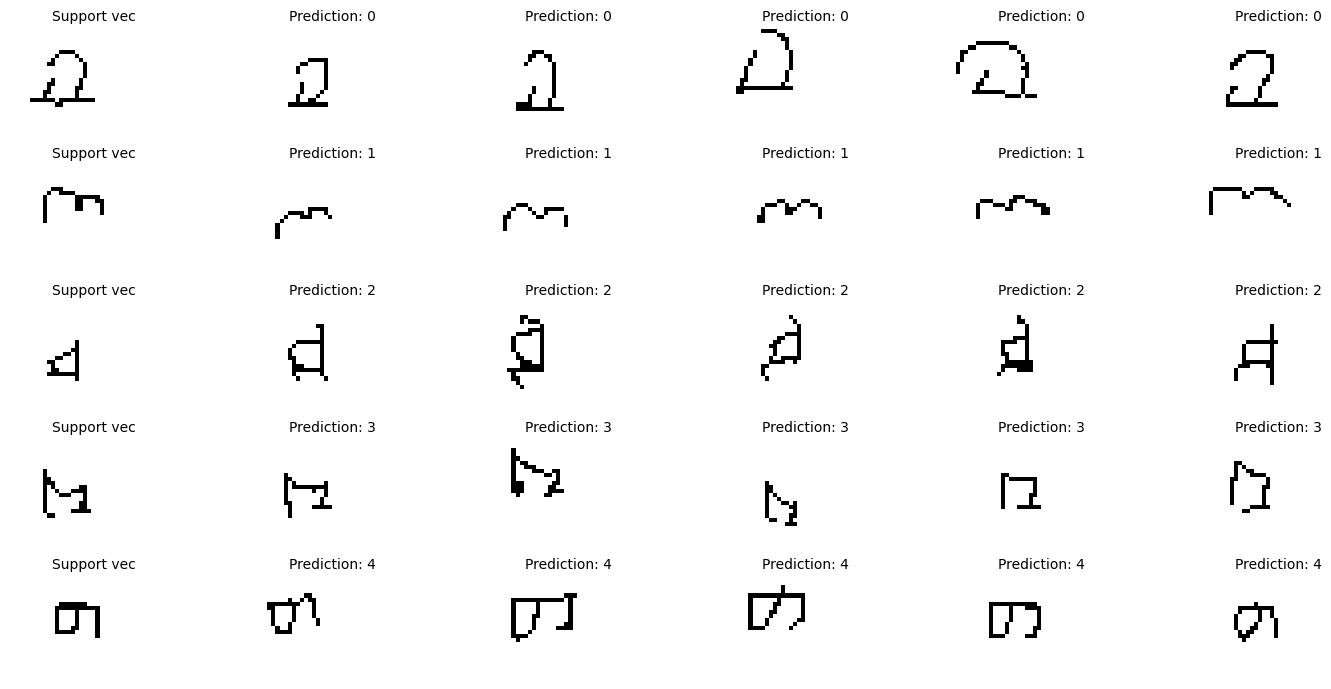

In [71]:
display_sample(my_sample['images'], prediction=output["prediction"], n_sup=n_support)